# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

In [1]:
print("hello world!")

hello world!


## Imports entire notebook

In [2]:
# Helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")


# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm.notebook import tqdm
import os
import shutil
import subprocess
import zipfile
import re
import random

Running in Google Colab


## Global Definitions

In [3]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [4]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.6.0+cu124
12.4
90300
False


In [5]:
# If we are in colab and we need to mount the drive
if is_colab():
  from google.colab import drive
  # Mount Google Drive
  drive.mount('/content/drive')
  print("Google Drive mounted successfully.")
  data_path = f"/content/drive/MyDrive/{data_path}"
else:
  print("Not in Google Colab.")

Mounted at /content/drive
Google Drive mounted successfully.


# Load Data

In [6]:
train_dataset = loadmat(data_path)
Xtrain = train_dataset['Xtrain']
# Check the shape of the data
print("Shape of Xtrain:", Xtrain.shape)

# Display the first few rows of the data
print("First 10 rows of Xtrain:")
print(Xtrain[:10])

# Convert to a PyTorch tensor if needed
Xtrain_tensor = torch.tensor(Xtrain, dtype=torch.float32, device=device)
print("Xtrain as a PyTorch tensor:", Xtrain_tensor.shape)

Shape of Xtrain: (1000, 1)
First 10 rows of Xtrain:
[[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]
 [ 21]
 [ 32]
 [ 72]
 [138]
 [111]]
Xtrain as a PyTorch tensor: torch.Size([1000, 1])


# Generate plot of data

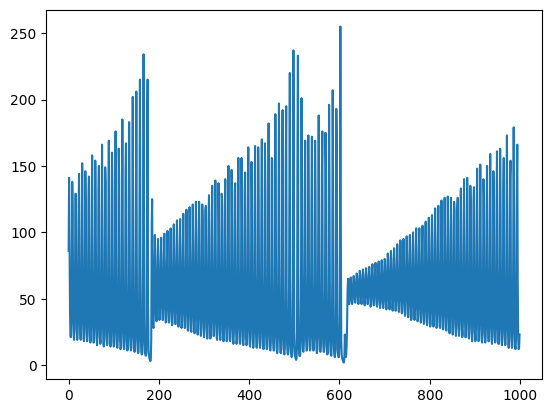

In [7]:
plt.plot(Xtrain)

# Divide data into training and test

In [33]:
trainingInputs = Xtrain_tensor[:800]
trainingExpectedOutputs = Xtrain_tensor[1:801]
testingInputs = Xtrain_tensor[800:999]
testingExpectedOutputs = Xtrain_tensor[801:]
print("Training shape: ", trainingInputs.shape, ". Testing shape", testingInputs.shape)
#print("Actual shape try", Xtrain_tensor[0:800])

Training shape:  torch.Size([800, 1]) . Testing shape torch.Size([199, 1])


# Model & Hyperparameters

In [26]:
input_size = 1
hidden_size = 128
sequence_length = 800
num_layers = 1

learning_rate = 0.001

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):#, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # With normal activation function (non-linearity), tanh, the loss function decreased slower.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='relu')

        # input: tensor of shape (sequence size, )

        # End with one fully connected layer from hidden to 1 number
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        # out: tensor of shape (sequence_length, hidden_size)
        # out (800, 128)

        # in the tutorial, the guy takes only the final number, like this:
        # out = out[-1,:]

        # run this through the final layer to get scalar?
        out = self.fc(out)
        return out



model = RNN(input_size, hidden_size, num_layers).to(device)
#model = torch.nn.RNN(input_size, hidden_size, num_layers).to(device)

# Loss function (maybe add optimizer?)

In [27]:
criterion = nn.MSELoss() # In the tutorial, crossentropyloss is used instead
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # We have to explain why we use adam

# Train the model

In [28]:
num_epochs = 500

for epoch in range(num_epochs):

  # Forward pass
  outputs = model(trainingInputs)

  loss = criterion(outputs, trainingExpectedOutputs)

  # Backpropagate
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Print loss
  if (epoch % 10 == 0):
    print("Epoch: ", epoch, ", loss:", loss.item())



Epoch:  0 , loss: 5864.861328125
Epoch:  10 , loss: 4410.05908203125
Epoch:  20 , loss: 3310.787109375
Epoch:  30 , loss: 4023.796875
Epoch:  40 , loss: 3919.570556640625
Epoch:  50 , loss: 3229.9697265625
Epoch:  60 , loss: 2464.47119140625
Epoch:  70 , loss: 2490.89453125
Epoch:  80 , loss: 2426.428955078125
Epoch:  90 , loss: 2396.66748046875
Epoch:  100 , loss: 2368.354736328125
Epoch:  110 , loss: 2339.2421875
Epoch:  120 , loss: 2304.496337890625
Epoch:  130 , loss: 2267.881591796875
Epoch:  140 , loss: 2226.843017578125
Epoch:  150 , loss: 2180.508056640625
Epoch:  160 , loss: 2128.0849609375
Epoch:  170 , loss: 2068.8935546875
Epoch:  180 , loss: 2002.953857421875
Epoch:  190 , loss: 1924.218017578125
Epoch:  200 , loss: 1832.0941162109375
Epoch:  210 , loss: 1796.3369140625
Epoch:  220 , loss: 1704.0582275390625
Epoch:  230 , loss: 1611.5313720703125
Epoch:  240 , loss: 1443.049560546875
Epoch:  250 , loss: 1168.4034423828125
Epoch:  260 , loss: 946.9332885742188
Epoch:  270 ,

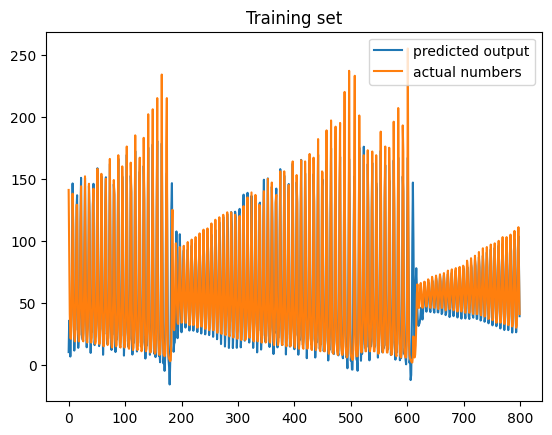

In [29]:
plt.title("Training set")
plt.plot(outputs.data, label="predicted output")
plt.plot(trainingExpectedOutputs, label="actual numbers")
plt.legend()

# Testing the model

MSE: 143.14218139648438


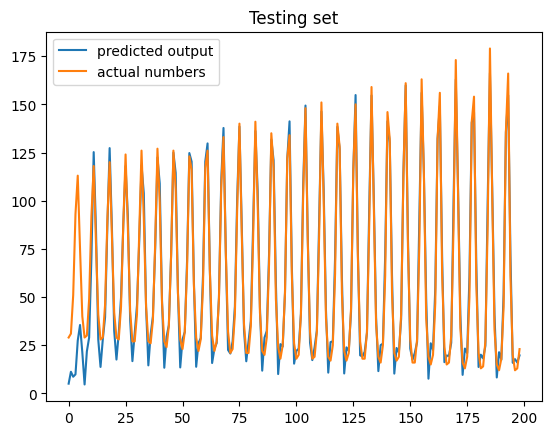

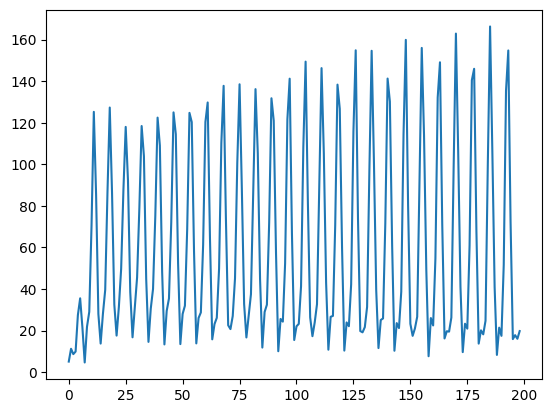

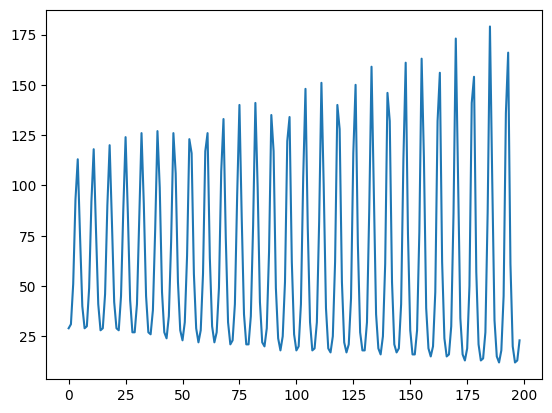

In [35]:
testingOutputs = model(testingInputs)

print("MSE:", criterion(testingOutputs, testingExpectedOutputs).item())

plt.title("Testing set")
plt.plot(testingOutputs.data, label="predicted output")
plt.plot(testingExpectedOutputs, label="actual numbers")
plt.legend()
plt.show()

plt.plot(testingOutputs.data)
plt.show()

plt.plot(testingExpectedOutputs)
plt.show()